All codes made with the help of Chatgpt and Github copilot by feeding the question subpart as the prompt

In [15]:
import torch
import torch.nn as nn
import numpy as np

class MultiHeadDifferentialAttention(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(MultiHeadDifferentialAttention, self).__init__()
        self.num_heads = num_heads
        self.embed_size = embed_size
        self.head_dim = embed_size // num_heads

        assert self.head_dim * num_heads == embed_size, "Embedding size must be divisible by number of heads."

        self.query_linear = nn.Linear(embed_size, embed_size)
        self.key_linear = nn.Linear(embed_size, embed_size)
        self.value_linear = nn.Linear(embed_size, embed_size)
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, query, key, value):
        N, seq_len, _ = query.shape

        # Linear projections
        Q = self.query_linear(query)  # (N, seq_len, embed_size)
        K = self.key_linear(key)
        V = self.value_linear(value)

        # Split into heads: (N, num_heads, seq_len, head_dim)
        Q = Q.view(N, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(N, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(N, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        # Differential Attention: compute (Q - K)
        diff = Q - K  # (N, num_heads, seq_len, head_dim)

        # Compute attention scores: (diff * V^T) / sqrt(d_k)
        scores = torch.matmul(diff, V.transpose(-2, -1)) / np.sqrt(self.head_dim)

        # Softmax over the last dimension (sequence length)
        attention_weights = torch.softmax(scores, dim=-1)

        # Final output: weighted sum of V
        out = torch.matmul(attention_weights, V)  # (N, num_heads, seq_len, head_dim)

        # Concatenate heads and project
        out = out.transpose(1, 2).contiguous().view(N, seq_len, self.embed_size)
        out = self.fc_out(out)  # (N, seq_len, embed_size)

        return out, attention_weights

class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_size, num_heads, feedforward_dim, dropout=0.1):
        super(TransformerEncoderBlock, self).__init__()
        self.multihead_attention = MultiHeadDifferentialAttention(embed_size, num_heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        self.ffn = nn.Sequential(
            nn.Linear(embed_size, feedforward_dim),
            nn.ReLU(),
            nn.Linear(feedforward_dim, embed_size)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Multi-head differential attention
        attention_out, _ = self.multihead_attention(x, x, x)
        x = self.norm1(x + self.dropout(attention_out))  # Skip connection

        # Feed-forward network
        ff_out = self.ffn(x)
        x = self.norm2(x + self.dropout(ff_out))  # Skip connection
        return x
    
class VisionTransformer(nn.Module):
    def __init__(self, num_classes, embed_size=256, num_heads=8, num_layers=6,
                 patch_size=4, feedforward_dim=1024, image_size=32,
                 positional_embedding_type="none"):  # Options: none, 1d_learned, 2d_learned, sinusoidal
        super(VisionTransformer, self).__init__()

        self.patch_size = patch_size
        self.embed_size = embed_size
        self.image_size = image_size
        self.num_patches = (image_size // patch_size) ** 2
        self.seq_len = self.num_patches + 1
        self.positional_embedding_type = positional_embedding_type

        self.conv1 = nn.Conv2d(3, embed_size, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_size))

        # Positional embedding
        if positional_embedding_type == "1d_learned":
            self.pos_embed = nn.Parameter(torch.randn(1, self.seq_len, embed_size))
        elif positional_embedding_type == "2d_learned":
            grid_size = image_size // patch_size
            self.pos_embed_2d = nn.Parameter(torch.randn(1, grid_size, grid_size, embed_size))
        elif positional_embedding_type == "sinusoidal":
            self.register_buffer("pos_embed", self.sinusoidal_embedding(self.seq_len, embed_size))
        else:  # none
            self.pos_embed = None

        self.encoder_layers = nn.ModuleList([
            TransformerEncoderBlock(embed_size, num_heads, feedforward_dim) for _ in range(num_layers)
        ])

        self.fc = nn.Linear(embed_size, num_classes)

    def sinusoidal_embedding(self, seq_len, dim):
        pe = torch.zeros(seq_len, dim)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2).float() * (-np.log(10000.0) / dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)

    def forward(self, x):
        x = self.conv1(x)
        x = x.flatten(2).transpose(1, 2)

        cls_tokens = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        if self.positional_embedding_type == "1d_learned":
            x = x + self.pos_embed
        elif self.positional_embedding_type == "2d_learned":
            B, _, _ = x.shape
            grid_size = self.image_size // self.patch_size
            pos_2d = self.pos_embed_2d.view(1, grid_size * grid_size, self.embed_size)
            pos = torch.cat([torch.zeros(1, 1, self.embed_size, device=x.device), pos_2d], dim=1)
            x = x + pos
        elif self.positional_embedding_type == "sinusoidal":
            x = x + self.pos_embed

        for layer in self.encoder_layers:
            x = layer(x)

        cls_output = x[:, 0]
        return self.fc(cls_output)

In [10]:
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, device, epochs=20, scheduler=None, save_path="best_vit_model.pth"):
    train_losses = []
    test_accuracies = []
    best_accuracy = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        batch_count = 0

        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                batch_count += 1

                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()

                pbar.set_postfix(
                    loss=running_loss / batch_count,
                    accuracy=100 * correct / total
                )

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Step the scheduler after each epoch
        if scheduler is not None:
            scheduler.step()

        # Evaluation
        model.eval()
        correct = 0
        total = 0

        with tqdm(test_loader, desc="Testing", unit="batch") as pbar:
            with torch.no_grad():
                for inputs, labels in pbar:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    pbar.set_postfix(accuracy=100 * correct / total)

        test_accuracy = 100 * correct / total
        test_accuracies.append(test_accuracy)

        # Save the best model
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save(model.state_dict(), save_path)
            print(f"✅ New best model saved at epoch {epoch+1} with {best_accuracy:.2f}% accuracy")

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {avg_train_loss:.4f} | Test Accuracy: {test_accuracy:.2f}% | LR: {current_lr:.6f}")

    return train_losses, test_accuracies


In [11]:
def plot_loss_and_accuracy(train_losses, test_accuracies, epochs):
    """
    Plots training loss and test accuracy curves over `epochs`.
    """
    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, marker='o')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, test_accuracies, marker='o')
    plt.title("Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")

    plt.tight_layout()
    plt.show()

Files already downloaded and verified
Files already downloaded and verified


Testing: 100%|██████████| 157/157 [00:02<00:00, 64.53batch/s, accuracy=44.7]


✅ New best model saved at epoch 1 with 44.71% accuracy
Epoch [1/20] | Loss: 1.7569 | Test Accuracy: 44.71% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:02<00:00, 64.24batch/s, accuracy=53.6]


✅ New best model saved at epoch 2 with 53.64% accuracy
Epoch [2/20] | Loss: 1.4109 | Test Accuracy: 53.64% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:02<00:00, 63.71batch/s, accuracy=55.5]


✅ New best model saved at epoch 3 with 55.48% accuracy
Epoch [3/20] | Loss: 1.2702 | Test Accuracy: 55.48% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:02<00:00, 63.23batch/s, accuracy=58.1]


✅ New best model saved at epoch 4 with 58.06% accuracy
Epoch [4/20] | Loss: 1.1660 | Test Accuracy: 58.06% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:02<00:00, 64.39batch/s, accuracy=60.4]


✅ New best model saved at epoch 5 with 60.40% accuracy
Epoch [5/20] | Loss: 1.0833 | Test Accuracy: 60.40% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:02<00:00, 64.11batch/s, accuracy=60.4]


Epoch [6/20] | Loss: 1.0099 | Test Accuracy: 60.36% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:02<00:00, 63.59batch/s, accuracy=60.2]


Epoch [7/20] | Loss: 0.9453 | Test Accuracy: 60.23% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:02<00:00, 64.00batch/s, accuracy=62.2]


✅ New best model saved at epoch 8 with 62.25% accuracy
Epoch [8/20] | Loss: 0.8821 | Test Accuracy: 62.25% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:02<00:00, 63.10batch/s, accuracy=62.7]


✅ New best model saved at epoch 9 with 62.67% accuracy
Epoch [9/20] | Loss: 0.8181 | Test Accuracy: 62.67% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:02<00:00, 63.85batch/s, accuracy=62.3]


Epoch [10/20] | Loss: 0.7573 | Test Accuracy: 62.28% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:02<00:00, 64.37batch/s, accuracy=62.6]


Epoch [11/20] | Loss: 0.6936 | Test Accuracy: 62.61% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:02<00:00, 64.08batch/s, accuracy=63.7]


✅ New best model saved at epoch 12 with 63.68% accuracy
Epoch [12/20] | Loss: 0.6292 | Test Accuracy: 63.68% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:02<00:00, 64.04batch/s, accuracy=62]  


Epoch [13/20] | Loss: 0.5740 | Test Accuracy: 61.96% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:02<00:00, 63.90batch/s, accuracy=63.6]


Epoch [14/20] | Loss: 0.5086 | Test Accuracy: 63.56% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:02<00:00, 63.70batch/s, accuracy=63.1]


Epoch [15/20] | Loss: 0.4559 | Test Accuracy: 63.07% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:02<00:00, 64.23batch/s, accuracy=63.7]


Epoch [16/20] | Loss: 0.4042 | Test Accuracy: 63.67% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:02<00:00, 64.13batch/s, accuracy=62.1]


Epoch [17/20] | Loss: 0.3548 | Test Accuracy: 62.15% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:02<00:00, 61.10batch/s, accuracy=63.4]


Epoch [18/20] | Loss: 0.3073 | Test Accuracy: 63.41% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:02<00:00, 63.78batch/s, accuracy=62]  


Epoch [19/20] | Loss: 0.2780 | Test Accuracy: 62.00% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:02<00:00, 63.80batch/s, accuracy=62.9]


Epoch [20/20] | Loss: 0.2482 | Test Accuracy: 62.91% | LR: 0.000100


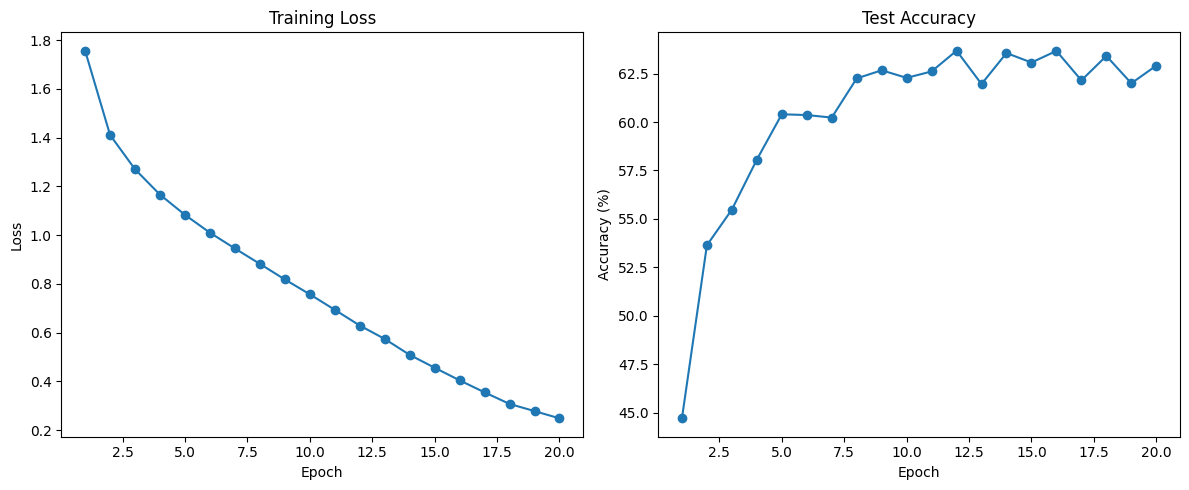

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- CIFAR-10 Dataset ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# --- Loss, Optimizer, Scheduler ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate your Diff-ViT here
model = VisionTransformer(
    num_classes=10,
    embed_size=256,
    num_heads=8,
    num_layers=6,
    patch_size=4,  # or 2
    feedforward_dim=1024,
    image_size=32,
    positional_embedding_type="1d_learned"  # or try others
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# --- Training + Evaluation ---
train_losses, test_accuracies = train_and_evaluate(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=20,
    #scheduler=scheduler,
    save_path="best_diff_vit.pth"
)

# --- Plotting ---
plot_loss_and_accuracy(train_losses, test_accuracies, epochs=20)

best accuracy for base differential attention head model (same params as base vit) no data augmentation and positional embeddings was 63.68% which falls short of the same base VIT which had 66.8% test accuracy with same conditions , the way i see it , this configuration is severely overfitting on training (look how steep the loss curve is and how plateued the test accuracy is)

now for patch size 2

Testing: 100%|██████████| 157/157 [00:09<00:00, 17.01batch/s, accuracy=42.8]


✅ New best model saved at epoch 1 with 42.84% accuracy
Epoch [1/10] | Loss: 1.8573 | Test Accuracy: 42.84% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:09<00:00, 17.08batch/s, accuracy=49.6]


✅ New best model saved at epoch 2 with 49.63% accuracy
Epoch [2/10] | Loss: 1.5169 | Test Accuracy: 49.63% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:09<00:00, 16.94batch/s, accuracy=52.5]


✅ New best model saved at epoch 3 with 52.55% accuracy
Epoch [3/10] | Loss: 1.3534 | Test Accuracy: 52.55% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:09<00:00, 16.84batch/s, accuracy=55]  


✅ New best model saved at epoch 4 with 54.96% accuracy
Epoch [4/10] | Loss: 1.2528 | Test Accuracy: 54.96% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:09<00:00, 16.49batch/s, accuracy=57]  


✅ New best model saved at epoch 5 with 57.01% accuracy
Epoch [5/10] | Loss: 1.1655 | Test Accuracy: 57.01% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:09<00:00, 16.74batch/s, accuracy=57.5]


✅ New best model saved at epoch 6 with 57.53% accuracy
Epoch [6/10] | Loss: 1.1018 | Test Accuracy: 57.53% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:09<00:00, 16.78batch/s, accuracy=58.8]


✅ New best model saved at epoch 7 with 58.79% accuracy
Epoch [7/10] | Loss: 1.0370 | Test Accuracy: 58.79% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:09<00:00, 16.78batch/s, accuracy=59.8]


✅ New best model saved at epoch 8 with 59.76% accuracy
Epoch [8/10] | Loss: 0.9752 | Test Accuracy: 59.76% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:09<00:00, 16.75batch/s, accuracy=61.5]


✅ New best model saved at epoch 9 with 61.50% accuracy
Epoch [9/10] | Loss: 0.9232 | Test Accuracy: 61.50% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:09<00:00, 16.80batch/s, accuracy=61.2]


Epoch [10/10] | Loss: 0.8653 | Test Accuracy: 61.17% | LR: 0.000100


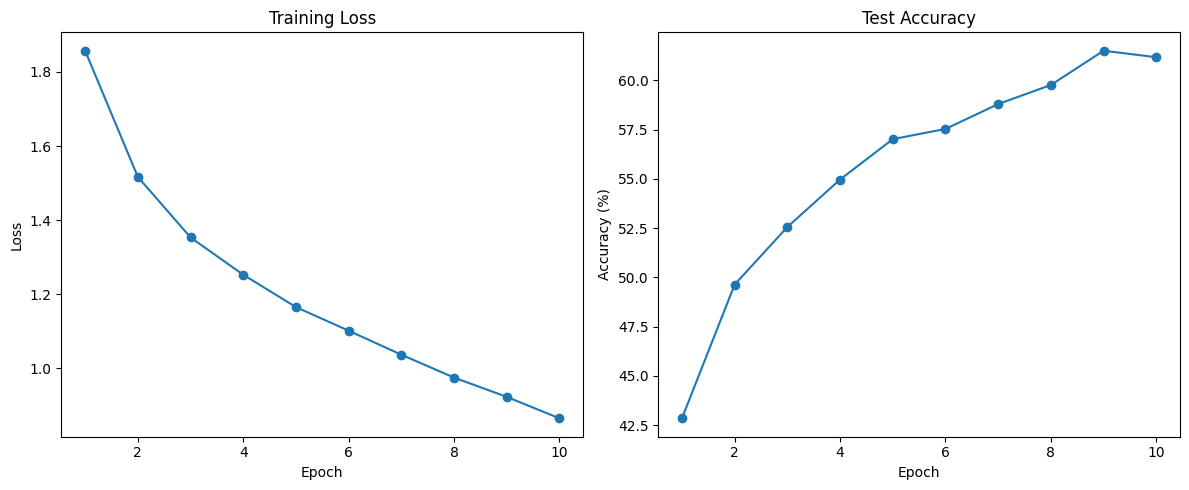

In [17]:
# --- Loss, Optimizer, Scheduler ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate your Diff-ViT here
model = VisionTransformer(
    num_classes=10,
    embed_size=256,
    num_heads=8,
    num_layers=6,
    patch_size=2,  # or 2
    feedforward_dim=1024,
    image_size=32,
    positional_embedding_type="1d_learned"  # or try others
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4,weight_decay=1e-2)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# --- Training + Evaluation ---
train_losses, test_accuracies = train_and_evaluate(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=10,
    #scheduler=scheduler,
    save_path="best_diff_vit.pth"
)

# --- Plotting ---
plot_loss_and_accuracy(train_losses, test_accuracies, epochs=10)

this one learned till 61.5% accuracy for patch size=2 beating the base vit model patch size =2 which stood at 59.39% test accuracy for the same number of epochs,

Now lets move on to hyper parameter tuning and data augmentation in hopes of getting the model beyond 80% test accuracy , we will first try the hyper params which gave best results for the base vit model

In [18]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Updated data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),            # Random crop with padding
    transforms.RandomHorizontalFlip(),               # Random horizontal flip
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                         std=[0.5, 0.5, 0.5])
])

# Keep test transform simple and consistent
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                         std=[0.5, 0.5, 0.5])
])

# Apply transforms
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Testing: 100%|██████████| 157/157 [00:03<00:00, 43.87batch/s, accuracy=43.2]


✅ New best model saved at epoch 1 with 43.22% accuracy
Epoch [1/50] | Loss: 1.7408 | Test Accuracy: 43.22% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:04<00:00, 39.03batch/s, accuracy=52.6]


✅ New best model saved at epoch 2 with 52.56% accuracy
Epoch [2/50] | Loss: 1.3596 | Test Accuracy: 52.56% | LR: 0.000100


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.44batch/s, accuracy=57.4]


✅ New best model saved at epoch 3 with 57.37% accuracy
Epoch [3/50] | Loss: 1.2191 | Test Accuracy: 57.37% | LR: 0.000099


Testing: 100%|██████████| 157/157 [00:04<00:00, 36.35batch/s, accuracy=58.5]


✅ New best model saved at epoch 4 with 58.52% accuracy
Epoch [4/50] | Loss: 1.1264 | Test Accuracy: 58.52% | LR: 0.000098


Testing: 100%|██████████| 157/157 [00:03<00:00, 41.77batch/s, accuracy=61.4]


✅ New best model saved at epoch 5 with 61.43% accuracy
Epoch [5/50] | Loss: 1.0666 | Test Accuracy: 61.43% | LR: 0.000098


Testing: 100%|██████████| 157/157 [00:03<00:00, 41.38batch/s, accuracy=62.5]


✅ New best model saved at epoch 6 with 62.47% accuracy
Epoch [6/50] | Loss: 1.0128 | Test Accuracy: 62.47% | LR: 0.000096


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.67batch/s, accuracy=63.5]


✅ New best model saved at epoch 7 with 63.51% accuracy
Epoch [7/50] | Loss: 0.9738 | Test Accuracy: 63.51% | LR: 0.000095


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.87batch/s, accuracy=66.7]


✅ New best model saved at epoch 8 with 66.67% accuracy
Epoch [8/50] | Loss: 0.9396 | Test Accuracy: 66.67% | LR: 0.000094


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.68batch/s, accuracy=66.2]


Epoch [9/50] | Loss: 0.8956 | Test Accuracy: 66.25% | LR: 0.000092


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.64batch/s, accuracy=68.5]


✅ New best model saved at epoch 10 with 68.55% accuracy
Epoch [10/50] | Loss: 0.8676 | Test Accuracy: 68.55% | LR: 0.000090


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.96batch/s, accuracy=68.8]


✅ New best model saved at epoch 11 with 68.85% accuracy
Epoch [11/50] | Loss: 0.8315 | Test Accuracy: 68.85% | LR: 0.000089


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.56batch/s, accuracy=68.7]


Epoch [12/50] | Loss: 0.8077 | Test Accuracy: 68.66% | LR: 0.000086


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.86batch/s, accuracy=69.2]


✅ New best model saved at epoch 13 with 69.17% accuracy
Epoch [13/50] | Loss: 0.7747 | Test Accuracy: 69.17% | LR: 0.000084


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.80batch/s, accuracy=71]  


✅ New best model saved at epoch 14 with 71.00% accuracy
Epoch [14/50] | Loss: 0.7494 | Test Accuracy: 71.00% | LR: 0.000082


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.96batch/s, accuracy=71.2]


✅ New best model saved at epoch 15 with 71.15% accuracy
Epoch [15/50] | Loss: 0.7218 | Test Accuracy: 71.15% | LR: 0.000079


Testing: 100%|██████████| 157/157 [00:04<00:00, 35.62batch/s, accuracy=71.5]


✅ New best model saved at epoch 16 with 71.55% accuracy
Epoch [16/50] | Loss: 0.6993 | Test Accuracy: 71.55% | LR: 0.000077


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.87batch/s, accuracy=70.9]


Epoch [17/50] | Loss: 0.6760 | Test Accuracy: 70.94% | LR: 0.000074


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.66batch/s, accuracy=72.6]


✅ New best model saved at epoch 18 with 72.60% accuracy
Epoch [18/50] | Loss: 0.6495 | Test Accuracy: 72.60% | LR: 0.000071


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.95batch/s, accuracy=73]  


✅ New best model saved at epoch 19 with 73.04% accuracy
Epoch [19/50] | Loss: 0.6283 | Test Accuracy: 73.04% | LR: 0.000068


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.55batch/s, accuracy=73.3]


✅ New best model saved at epoch 20 with 73.29% accuracy
Epoch [20/50] | Loss: 0.6053 | Test Accuracy: 73.29% | LR: 0.000065


Testing: 100%|██████████| 157/157 [00:03<00:00, 41.07batch/s, accuracy=73.5]


✅ New best model saved at epoch 21 with 73.48% accuracy
Epoch [21/50] | Loss: 0.5805 | Test Accuracy: 73.48% | LR: 0.000062


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.98batch/s, accuracy=73.8]


✅ New best model saved at epoch 22 with 73.78% accuracy
Epoch [22/50] | Loss: 0.5620 | Test Accuracy: 73.78% | LR: 0.000059


Testing: 100%|██████████| 157/157 [00:04<00:00, 35.29batch/s, accuracy=74.1]


✅ New best model saved at epoch 23 with 74.06% accuracy
Epoch [23/50] | Loss: 0.5376 | Test Accuracy: 74.06% | LR: 0.000056


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.76batch/s, accuracy=74.6]


✅ New best model saved at epoch 24 with 74.63% accuracy
Epoch [24/50] | Loss: 0.5157 | Test Accuracy: 74.63% | LR: 0.000053


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.89batch/s, accuracy=74.3]


Epoch [25/50] | Loss: 0.4951 | Test Accuracy: 74.35% | LR: 0.000050


Testing: 100%|██████████| 157/157 [00:03<00:00, 41.16batch/s, accuracy=75.2]


✅ New best model saved at epoch 26 with 75.15% accuracy
Epoch [26/50] | Loss: 0.4704 | Test Accuracy: 75.15% | LR: 0.000047


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.96batch/s, accuracy=74.7]


Epoch [27/50] | Loss: 0.4500 | Test Accuracy: 74.73% | LR: 0.000044


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.89batch/s, accuracy=75.1]


Epoch [28/50] | Loss: 0.4303 | Test Accuracy: 75.10% | LR: 0.000041


Testing: 100%|██████████| 157/157 [00:04<00:00, 34.06batch/s, accuracy=74.6]


Epoch [29/50] | Loss: 0.4108 | Test Accuracy: 74.64% | LR: 0.000038


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.98batch/s, accuracy=75.6]


✅ New best model saved at epoch 30 with 75.64% accuracy
Epoch [30/50] | Loss: 0.3948 | Test Accuracy: 75.64% | LR: 0.000035


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.12batch/s, accuracy=75.7]


✅ New best model saved at epoch 31 with 75.66% accuracy
Epoch [31/50] | Loss: 0.3748 | Test Accuracy: 75.66% | LR: 0.000032


Testing: 100%|██████████| 157/157 [00:03<00:00, 41.34batch/s, accuracy=75.9]


✅ New best model saved at epoch 32 with 75.90% accuracy
Epoch [32/50] | Loss: 0.3530 | Test Accuracy: 75.90% | LR: 0.000029


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.75batch/s, accuracy=76.1]


✅ New best model saved at epoch 33 with 76.07% accuracy
Epoch [33/50] | Loss: 0.3346 | Test Accuracy: 76.07% | LR: 0.000026


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.94batch/s, accuracy=76]  


Epoch [34/50] | Loss: 0.3192 | Test Accuracy: 75.99% | LR: 0.000023


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.61batch/s, accuracy=75.9]


Epoch [35/50] | Loss: 0.3062 | Test Accuracy: 75.89% | LR: 0.000021


Testing: 100%|██████████| 157/157 [00:04<00:00, 38.58batch/s, accuracy=76.2]


✅ New best model saved at epoch 36 with 76.25% accuracy
Epoch [36/50] | Loss: 0.2936 | Test Accuracy: 76.25% | LR: 0.000018


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.43batch/s, accuracy=76.7]


✅ New best model saved at epoch 37 with 76.67% accuracy
Epoch [37/50] | Loss: 0.2804 | Test Accuracy: 76.67% | LR: 0.000016


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.88batch/s, accuracy=76.8]


✅ New best model saved at epoch 38 with 76.84% accuracy
Epoch [38/50] | Loss: 0.2723 | Test Accuracy: 76.84% | LR: 0.000014


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.23batch/s, accuracy=76.7]


Epoch [39/50] | Loss: 0.2561 | Test Accuracy: 76.72% | LR: 0.000011


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.88batch/s, accuracy=76.5]


Epoch [40/50] | Loss: 0.2445 | Test Accuracy: 76.55% | LR: 0.000010


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.69batch/s, accuracy=76.9]


✅ New best model saved at epoch 41 with 76.91% accuracy
Epoch [41/50] | Loss: 0.2401 | Test Accuracy: 76.91% | LR: 0.000008


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.26batch/s, accuracy=76.8]


Epoch [42/50] | Loss: 0.2281 | Test Accuracy: 76.84% | LR: 0.000006


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.99batch/s, accuracy=77]  


✅ New best model saved at epoch 43 with 77.05% accuracy
Epoch [43/50] | Loss: 0.2199 | Test Accuracy: 77.05% | LR: 0.000005


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.69batch/s, accuracy=77]  


Epoch [44/50] | Loss: 0.2155 | Test Accuracy: 77.00% | LR: 0.000004


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.58batch/s, accuracy=76.7]


Epoch [45/50] | Loss: 0.2114 | Test Accuracy: 76.72% | LR: 0.000002


Testing: 100%|██████████| 157/157 [00:03<00:00, 41.10batch/s, accuracy=77.1]


✅ New best model saved at epoch 46 with 77.07% accuracy
Epoch [46/50] | Loss: 0.2116 | Test Accuracy: 77.07% | LR: 0.000002


Testing: 100%|██████████| 157/157 [00:04<00:00, 39.05batch/s, accuracy=77]  


Epoch [47/50] | Loss: 0.2041 | Test Accuracy: 77.01% | LR: 0.000001


Testing: 100%|██████████| 157/157 [00:04<00:00, 32.15batch/s, accuracy=77]  


Epoch [48/50] | Loss: 0.2027 | Test Accuracy: 76.97% | LR: 0.000000


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.55batch/s, accuracy=77]  


Epoch [49/50] | Loss: 0.2005 | Test Accuracy: 76.95% | LR: 0.000000


Testing: 100%|██████████| 157/157 [00:03<00:00, 40.07batch/s, accuracy=77]  


Epoch [50/50] | Loss: 0.2023 | Test Accuracy: 76.95% | LR: 0.000000


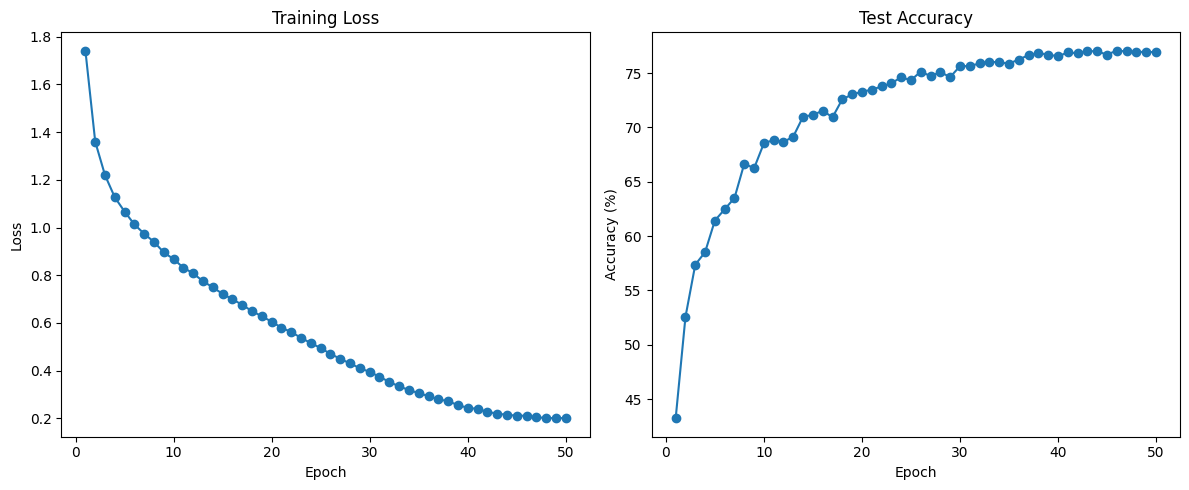

🎯 Final Test Accuracy for DiffViT (patch size 4): 76.95%


In [20]:
# Assuming device, train_loader, test_loader, criterion are already defined
patch_size = 4  # or 2, based on experiment

# Instantiate Differential Vision Transformer
diff_vit_model = VisionTransformer(
    num_classes=10,
    embed_size=256,
    num_heads=8,
    num_layers=12,
    patch_size=patch_size,
    feedforward_dim=1024,
    positional_embedding_type="none"  # or "none", "2d_learned", etc.
).to(device)

# Optimizer and scheduler
optimizer = torch.optim.AdamW(diff_vit_model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# Train + evaluate
train_losses, test_accuracies = train_and_evaluate(
    model=diff_vit_model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=50,
    scheduler=scheduler,
    save_path="best_diffvit_deep.pth"
)

# Plot results
plot_loss_and_accuracy(train_losses, test_accuracies, epochs=50)
print(f"🎯 Final Test Accuracy for DiffViT (patch size {patch_size}): {test_accuracies[-1]:.2f}%")


the same config overfit very early on with train accuracy reaching 93% while test plateued at 77% , which couldnt ultimately beat 78.06% of the base Vit model

now for the positional embeddings


🔁 Training DiffViT with positional embedding type: none



Testing: 100%|██████████| 157/157 [00:01<00:00, 98.49batch/s, accuracy=39.3]


✅ New best model saved at epoch 1 with 39.28% accuracy
Epoch [1/10] | Loss: 1.8058 | Test Accuracy: 39.28% | LR: 0.000098


Testing: 100%|██████████| 157/157 [00:01<00:00, 97.50batch/s, accuracy=48.8]


✅ New best model saved at epoch 2 with 48.78% accuracy
Epoch [2/10] | Loss: 1.5130 | Test Accuracy: 48.78% | LR: 0.000090


Testing: 100%|██████████| 157/157 [00:01<00:00, 95.12batch/s, accuracy=50.4]


✅ New best model saved at epoch 3 with 50.42% accuracy
Epoch [3/10] | Loss: 1.3698 | Test Accuracy: 50.42% | LR: 0.000079


Testing: 100%|██████████| 157/157 [00:01<00:00, 97.41batch/s, accuracy=54.8]


✅ New best model saved at epoch 4 with 54.82% accuracy
Epoch [4/10] | Loss: 1.3037 | Test Accuracy: 54.82% | LR: 0.000065


Testing: 100%|██████████| 157/157 [00:01<00:00, 97.80batch/s, accuracy=53.3]


Epoch [5/10] | Loss: 1.2559 | Test Accuracy: 53.26% | LR: 0.000050


Testing: 100%|██████████| 157/157 [00:01<00:00, 96.35batch/s, accuracy=55.9]


✅ New best model saved at epoch 6 with 55.91% accuracy
Epoch [6/10] | Loss: 1.2160 | Test Accuracy: 55.91% | LR: 0.000035


Testing: 100%|██████████| 157/157 [00:01<00:00, 96.08batch/s, accuracy=56.1]


✅ New best model saved at epoch 7 with 56.14% accuracy
Epoch [7/10] | Loss: 1.1806 | Test Accuracy: 56.14% | LR: 0.000021


Testing: 100%|██████████| 157/157 [00:01<00:00, 93.24batch/s, accuracy=58.4]


✅ New best model saved at epoch 8 with 58.44% accuracy
Epoch [8/10] | Loss: 1.1606 | Test Accuracy: 58.44% | LR: 0.000010


Testing: 100%|██████████| 157/157 [00:01<00:00, 92.38batch/s, accuracy=58.2]


Epoch [9/10] | Loss: 1.1410 | Test Accuracy: 58.17% | LR: 0.000002


Testing: 100%|██████████| 157/157 [00:01<00:00, 90.07batch/s, accuracy=58.7]


✅ New best model saved at epoch 10 with 58.68% accuracy
Epoch [10/10] | Loss: 1.1311 | Test Accuracy: 58.68% | LR: 0.000000


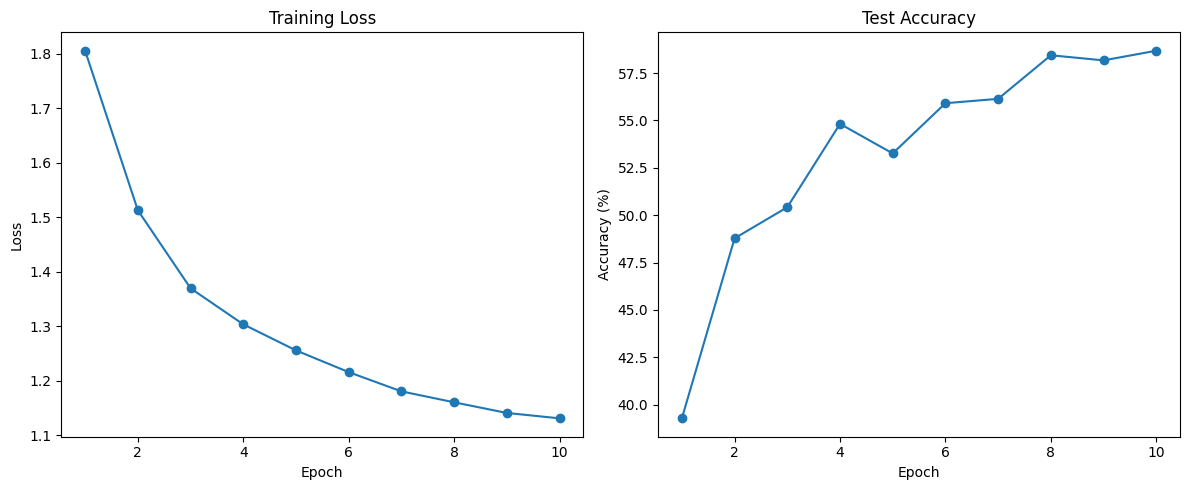

✅ Final Test Accuracy for DiffViT (none): 58.68%

🔁 Training DiffViT with positional embedding type: 1d_learned



Testing: 100%|██████████| 157/157 [00:01<00:00, 92.47batch/s, accuracy=38]  


✅ New best model saved at epoch 1 with 37.98% accuracy
Epoch [1/10] | Loss: 1.9681 | Test Accuracy: 37.98% | LR: 0.000098


Testing: 100%|██████████| 157/157 [00:01<00:00, 91.14batch/s, accuracy=43.4]


✅ New best model saved at epoch 2 with 43.36% accuracy
Epoch [2/10] | Loss: 1.7263 | Test Accuracy: 43.36% | LR: 0.000090


Testing: 100%|██████████| 157/157 [00:01<00:00, 90.63batch/s, accuracy=47.4]


✅ New best model saved at epoch 3 with 47.41% accuracy
Epoch [3/10] | Loss: 1.6013 | Test Accuracy: 47.41% | LR: 0.000079


Testing: 100%|██████████| 157/157 [00:01<00:00, 87.25batch/s, accuracy=48.9]


✅ New best model saved at epoch 4 with 48.93% accuracy
Epoch [4/10] | Loss: 1.5221 | Test Accuracy: 48.93% | LR: 0.000065


Testing: 100%|██████████| 157/157 [00:01<00:00, 87.77batch/s, accuracy=50.6]


✅ New best model saved at epoch 5 with 50.58% accuracy
Epoch [5/10] | Loss: 1.4652 | Test Accuracy: 50.58% | LR: 0.000050


Testing: 100%|██████████| 157/157 [00:01<00:00, 83.43batch/s, accuracy=52]  


✅ New best model saved at epoch 6 with 51.96% accuracy
Epoch [6/10] | Loss: 1.4192 | Test Accuracy: 51.96% | LR: 0.000035


Testing: 100%|██████████| 157/157 [00:01<00:00, 86.82batch/s, accuracy=53.4]


✅ New best model saved at epoch 7 with 53.37% accuracy
Epoch [7/10] | Loss: 1.3911 | Test Accuracy: 53.37% | LR: 0.000021


Testing: 100%|██████████| 157/157 [00:01<00:00, 87.32batch/s, accuracy=53.3]


Epoch [8/10] | Loss: 1.3677 | Test Accuracy: 53.28% | LR: 0.000010


Testing: 100%|██████████| 157/157 [00:01<00:00, 84.70batch/s, accuracy=53.6]


✅ New best model saved at epoch 9 with 53.59% accuracy
Epoch [9/10] | Loss: 1.3532 | Test Accuracy: 53.59% | LR: 0.000002


Testing: 100%|██████████| 157/157 [00:01<00:00, 83.06batch/s, accuracy=54]  


✅ New best model saved at epoch 10 with 53.98% accuracy
Epoch [10/10] | Loss: 1.3453 | Test Accuracy: 53.98% | LR: 0.000000


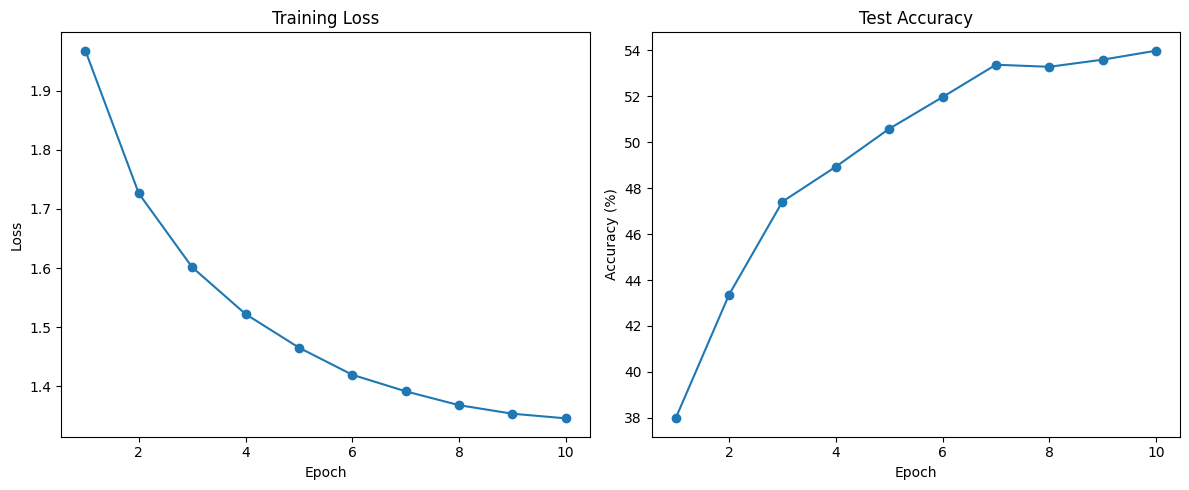

✅ Final Test Accuracy for DiffViT (1d_learned): 53.98%

🔁 Training DiffViT with positional embedding type: 2d_learned



Testing: 100%|██████████| 157/157 [00:01<00:00, 80.58batch/s, accuracy=35.9]


✅ New best model saved at epoch 1 with 35.91% accuracy
Epoch [1/10] | Loss: 1.9592 | Test Accuracy: 35.91% | LR: 0.000098


Testing: 100%|██████████| 157/157 [00:01<00:00, 83.29batch/s, accuracy=43.9]


✅ New best model saved at epoch 2 with 43.94% accuracy
Epoch [2/10] | Loss: 1.7245 | Test Accuracy: 43.94% | LR: 0.000090


Testing: 100%|██████████| 157/157 [00:01<00:00, 85.96batch/s, accuracy=47.4]


✅ New best model saved at epoch 3 with 47.36% accuracy
Epoch [3/10] | Loss: 1.5957 | Test Accuracy: 47.36% | LR: 0.000079


Testing: 100%|██████████| 157/157 [00:01<00:00, 85.00batch/s, accuracy=49.7]


✅ New best model saved at epoch 4 with 49.66% accuracy
Epoch [4/10] | Loss: 1.5165 | Test Accuracy: 49.66% | LR: 0.000065


Testing: 100%|██████████| 157/157 [00:01<00:00, 85.44batch/s, accuracy=50.8]


✅ New best model saved at epoch 5 with 50.84% accuracy
Epoch [5/10] | Loss: 1.4605 | Test Accuracy: 50.84% | LR: 0.000050


Testing: 100%|██████████| 157/157 [00:01<00:00, 86.89batch/s, accuracy=52.5]


✅ New best model saved at epoch 6 with 52.51% accuracy
Epoch [6/10] | Loss: 1.4118 | Test Accuracy: 52.51% | LR: 0.000035


Testing: 100%|██████████| 157/157 [00:01<00:00, 87.90batch/s, accuracy=52.7]


✅ New best model saved at epoch 7 with 52.66% accuracy
Epoch [7/10] | Loss: 1.3752 | Test Accuracy: 52.66% | LR: 0.000021


Testing: 100%|██████████| 157/157 [00:01<00:00, 86.91batch/s, accuracy=53.1]


✅ New best model saved at epoch 8 with 53.15% accuracy
Epoch [8/10] | Loss: 1.3557 | Test Accuracy: 53.15% | LR: 0.000010


Testing: 100%|██████████| 157/157 [00:01<00:00, 85.07batch/s, accuracy=54.2]


✅ New best model saved at epoch 9 with 54.19% accuracy
Epoch [9/10] | Loss: 1.3374 | Test Accuracy: 54.19% | LR: 0.000002


Testing: 100%|██████████| 157/157 [00:01<00:00, 85.86batch/s, accuracy=54]  


Epoch [10/10] | Loss: 1.3364 | Test Accuracy: 54.03% | LR: 0.000000


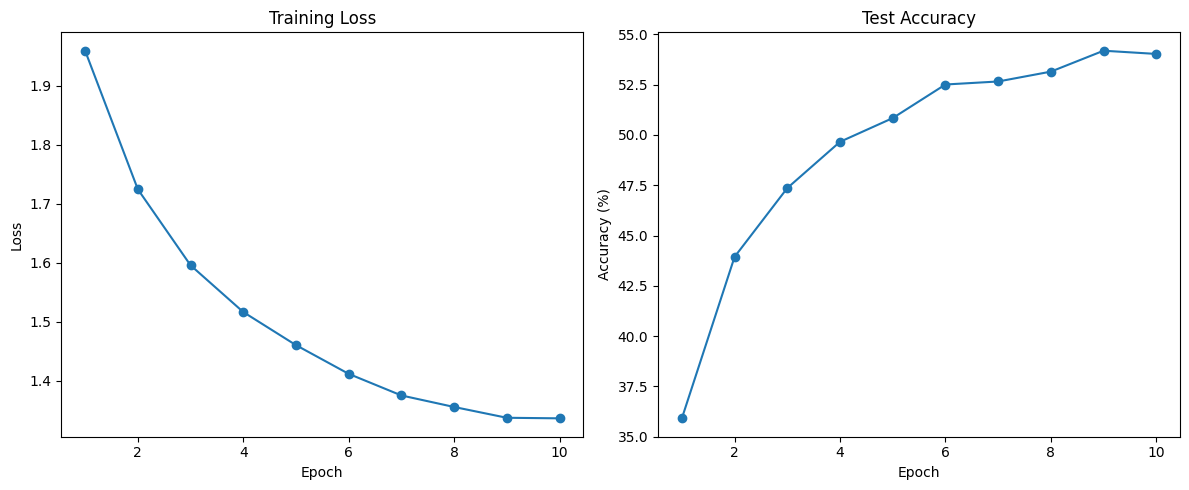

✅ Final Test Accuracy for DiffViT (2d_learned): 54.03%

🔁 Training DiffViT with positional embedding type: sinusoidal



Testing: 100%|██████████| 157/157 [00:01<00:00, 87.88batch/s, accuracy=43.4]


✅ New best model saved at epoch 1 with 43.41% accuracy
Epoch [1/10] | Loss: 1.8735 | Test Accuracy: 43.41% | LR: 0.000098


Testing: 100%|██████████| 157/157 [00:01<00:00, 87.54batch/s, accuracy=49.2]


✅ New best model saved at epoch 2 with 49.16% accuracy
Epoch [2/10] | Loss: 1.5536 | Test Accuracy: 49.16% | LR: 0.000090


Testing: 100%|██████████| 157/157 [00:01<00:00, 86.73batch/s, accuracy=52.5]


✅ New best model saved at epoch 3 with 52.51% accuracy
Epoch [3/10] | Loss: 1.4376 | Test Accuracy: 52.51% | LR: 0.000079


Testing: 100%|██████████| 157/157 [00:01<00:00, 78.84batch/s, accuracy=54.2]


✅ New best model saved at epoch 4 with 54.17% accuracy
Epoch [4/10] | Loss: 1.3596 | Test Accuracy: 54.17% | LR: 0.000065


Testing: 100%|██████████| 157/157 [00:01<00:00, 87.67batch/s, accuracy=56.5]


✅ New best model saved at epoch 5 with 56.50% accuracy
Epoch [5/10] | Loss: 1.3024 | Test Accuracy: 56.50% | LR: 0.000050


Testing: 100%|██████████| 157/157 [00:01<00:00, 87.42batch/s, accuracy=57]  


✅ New best model saved at epoch 6 with 57.02% accuracy
Epoch [6/10] | Loss: 1.2586 | Test Accuracy: 57.02% | LR: 0.000035


Testing: 100%|██████████| 157/157 [00:01<00:00, 87.09batch/s, accuracy=57.7]


✅ New best model saved at epoch 7 with 57.73% accuracy
Epoch [7/10] | Loss: 1.2289 | Test Accuracy: 57.73% | LR: 0.000021


Testing: 100%|██████████| 157/157 [00:01<00:00, 84.89batch/s, accuracy=58.5]


✅ New best model saved at epoch 8 with 58.54% accuracy
Epoch [8/10] | Loss: 1.2002 | Test Accuracy: 58.54% | LR: 0.000010


Testing: 100%|██████████| 157/157 [00:01<00:00, 85.74batch/s, accuracy=59.1]


✅ New best model saved at epoch 9 with 59.14% accuracy
Epoch [9/10] | Loss: 1.1841 | Test Accuracy: 59.14% | LR: 0.000002


Testing: 100%|██████████| 157/157 [00:01<00:00, 86.67batch/s, accuracy=59.4]


✅ New best model saved at epoch 10 with 59.35% accuracy
Epoch [10/10] | Loss: 1.1772 | Test Accuracy: 59.35% | LR: 0.000000


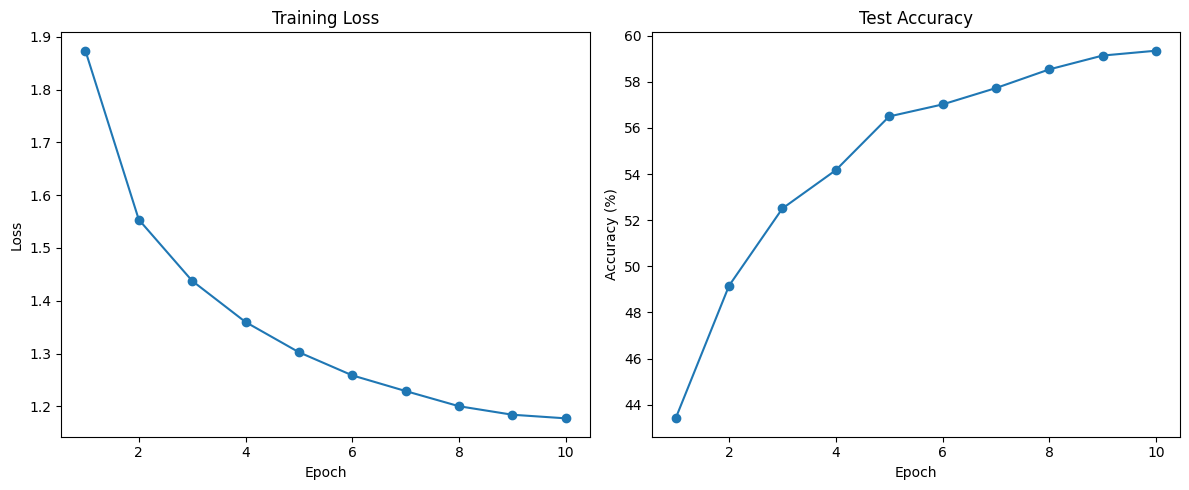

✅ Final Test Accuracy for DiffViT (sinusoidal): 59.35%

📊 Summary of Final Accuracies (DiffViT):
none: 58.68%
1d_learned: 53.98%
2d_learned: 54.03%
sinusoidal: 59.35%


In [21]:
embedding_types = ["none", "1d_learned", "2d_learned", "sinusoidal"]
diff_vit_results = {}

for emb_type in embedding_types:
    print(f"\n🔁 Training DiffViT with positional embedding type: {emb_type}\n")
    
    diff_vit_model = VisionTransformer(
        num_classes=10,
        embed_size=128,
        num_heads=4,
        num_layers=6,
        patch_size=4,
        feedforward_dim=512,
        positional_embedding_type=emb_type
    ).to(device)

    optimizer = torch.optim.AdamW(diff_vit_model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

    save_path = f"best_diff_vit_{emb_type}.pth"
    
    train_losses, test_accuracies = train_and_evaluate(
        model=diff_vit_model,
        train_loader=train_loader,
        test_loader=test_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        epochs=10,
        scheduler=scheduler,
        save_path=save_path
    )

    diff_vit_results[emb_type] = {
        "train_losses": train_losses,
        "test_accuracies": test_accuracies
    }

    plot_loss_and_accuracy(train_losses, test_accuracies, epochs=10)
    print(f"✅ Final Test Accuracy for DiffViT ({emb_type}): {test_accuracies[-1]:.2f}%")

# 📊 Summary
print("\n📊 Summary of Final Accuracies (DiffViT):")
for k in diff_vit_results:
    print(f"{k}: {diff_vit_results[k]['test_accuracies'][-1]:.2f}%")


comparision for positional embeddings

none -> base-vit=55.71% diff-vit=58.68%

1-d learned -> base-vit = 50.15% diff-vit= 53.98%

2-d learned -> base-vit = 50.93% diff-vit = 54.19%

sinusoidal -> base-vit = 54.41% diff-vit = 59.35%

Clearly the diff-vit performs better for the positional embeddings in all cases

🔍 Evaluating none positional embedding...


C:\Users\SHARS\AppData\Local\Temp\ipykernel_39324\2519179642.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"best_diff_vit_{emb_type}

✅ none: 58.68%
🔍 Evaluating 1d_learned positional embedding...
✅ 1d_learned: 53.98%
🔍 Evaluating 2d_learned positional embedding...
✅ 2d_learned: 54.19%
🔍 Evaluating sinusoidal positional embedding...
✅ sinusoidal: 59.35%


C:\Users\SHARS\AppData\Local\Temp\ipykernel_39324\2519179642.py:48: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\SHARS\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


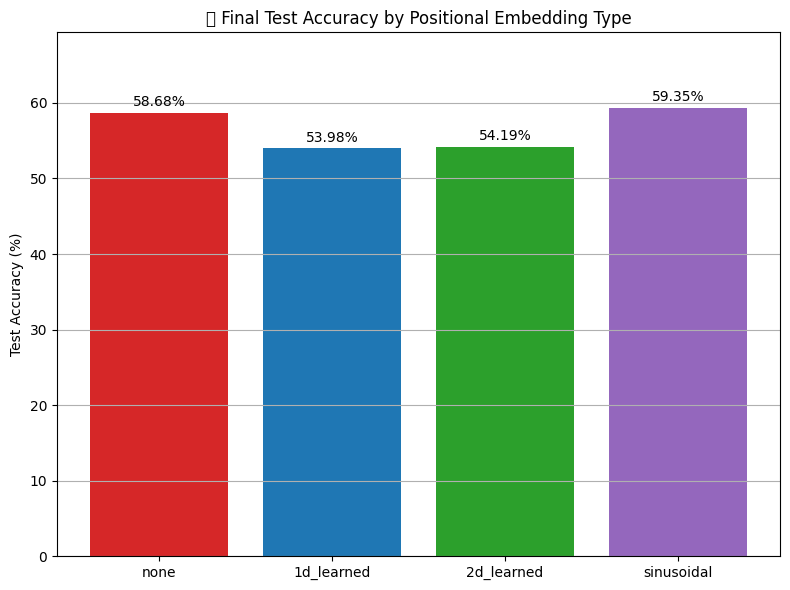

In [22]:
import torch
import matplotlib.pyplot as plt

embedding_types = ["none", "1d_learned", "2d_learned", "sinusoidal"]
accuracies = []

for emb_type in embedding_types:
    print(f"🔍 Evaluating {emb_type} positional embedding...")

    model = VisionTransformer(
        num_classes=10,
        embed_size=128,
        num_heads=4,
        num_layers=6,
        patch_size=4,
        feedforward_dim=512,
        positional_embedding_type=emb_type
    ).to(device)

    model.load_state_dict(torch.load(f"best_diff_vit_{emb_type}.pth"))
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    accuracies.append(accuracy)
    print(f"✅ {emb_type}: {accuracy:.2f}%")

# Plotting final test accuracies
plt.figure(figsize=(8, 6))
colors = ['#d62728', '#1f77b4', '#2ca02c', '#9467bd']
plt.bar(embedding_types, accuracies, color=colors)
plt.ylabel("Test Accuracy (%)")
plt.title("📊 Final Test Accuracy by Positional Embedding Type")
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.5, f"{acc:.2f}%", ha='center', va='bottom')
plt.ylim(0, max(accuracies) + 10)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Now for visualisations

Attention maps for the best diff vit model

In [26]:
class MultiHeadDifferentialAttention(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(MultiHeadDifferentialAttention, self).__init__()
        self.num_heads = num_heads
        self.embed_size = embed_size
        self.head_dim = embed_size // num_heads

        assert self.head_dim * num_heads == embed_size, "Embedding size must be divisible by number of heads."

        self.query_linear = nn.Linear(embed_size, embed_size)
        self.key_linear = nn.Linear(embed_size, embed_size)
        self.value_linear = nn.Linear(embed_size, embed_size)
        self.fc_out = nn.Linear(embed_size, embed_size)

        self.attn_weights = None  # 👈 This will store the attention for visualization

    def forward(self, query, key, value):
        N, seq_len, _ = query.shape

        Q = self.query_linear(query)
        K = self.key_linear(key)
        V = self.value_linear(value)

        Q = Q.view(N, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(N, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(N, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        diff = Q - K
        scores = torch.matmul(diff, V.transpose(-2, -1)) / np.sqrt(self.head_dim)
        attention_weights = torch.softmax(scores, dim=-1)

        self.attn_weights = attention_weights  # 👈 Store for hook use

        out = torch.matmul(attention_weights, V)
        out = out.transpose(1, 2).contiguous().view(N, seq_len, self.embed_size)
        out = self.fc_out(out)

        return out, attention_weights  # ✅ Same return type


C:\Users\SHARS\AppData\Local\Temp\ipykernel_39324\2700759057.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  diffvit_model.load_state_dict(torch.load('best_diffvit_deep

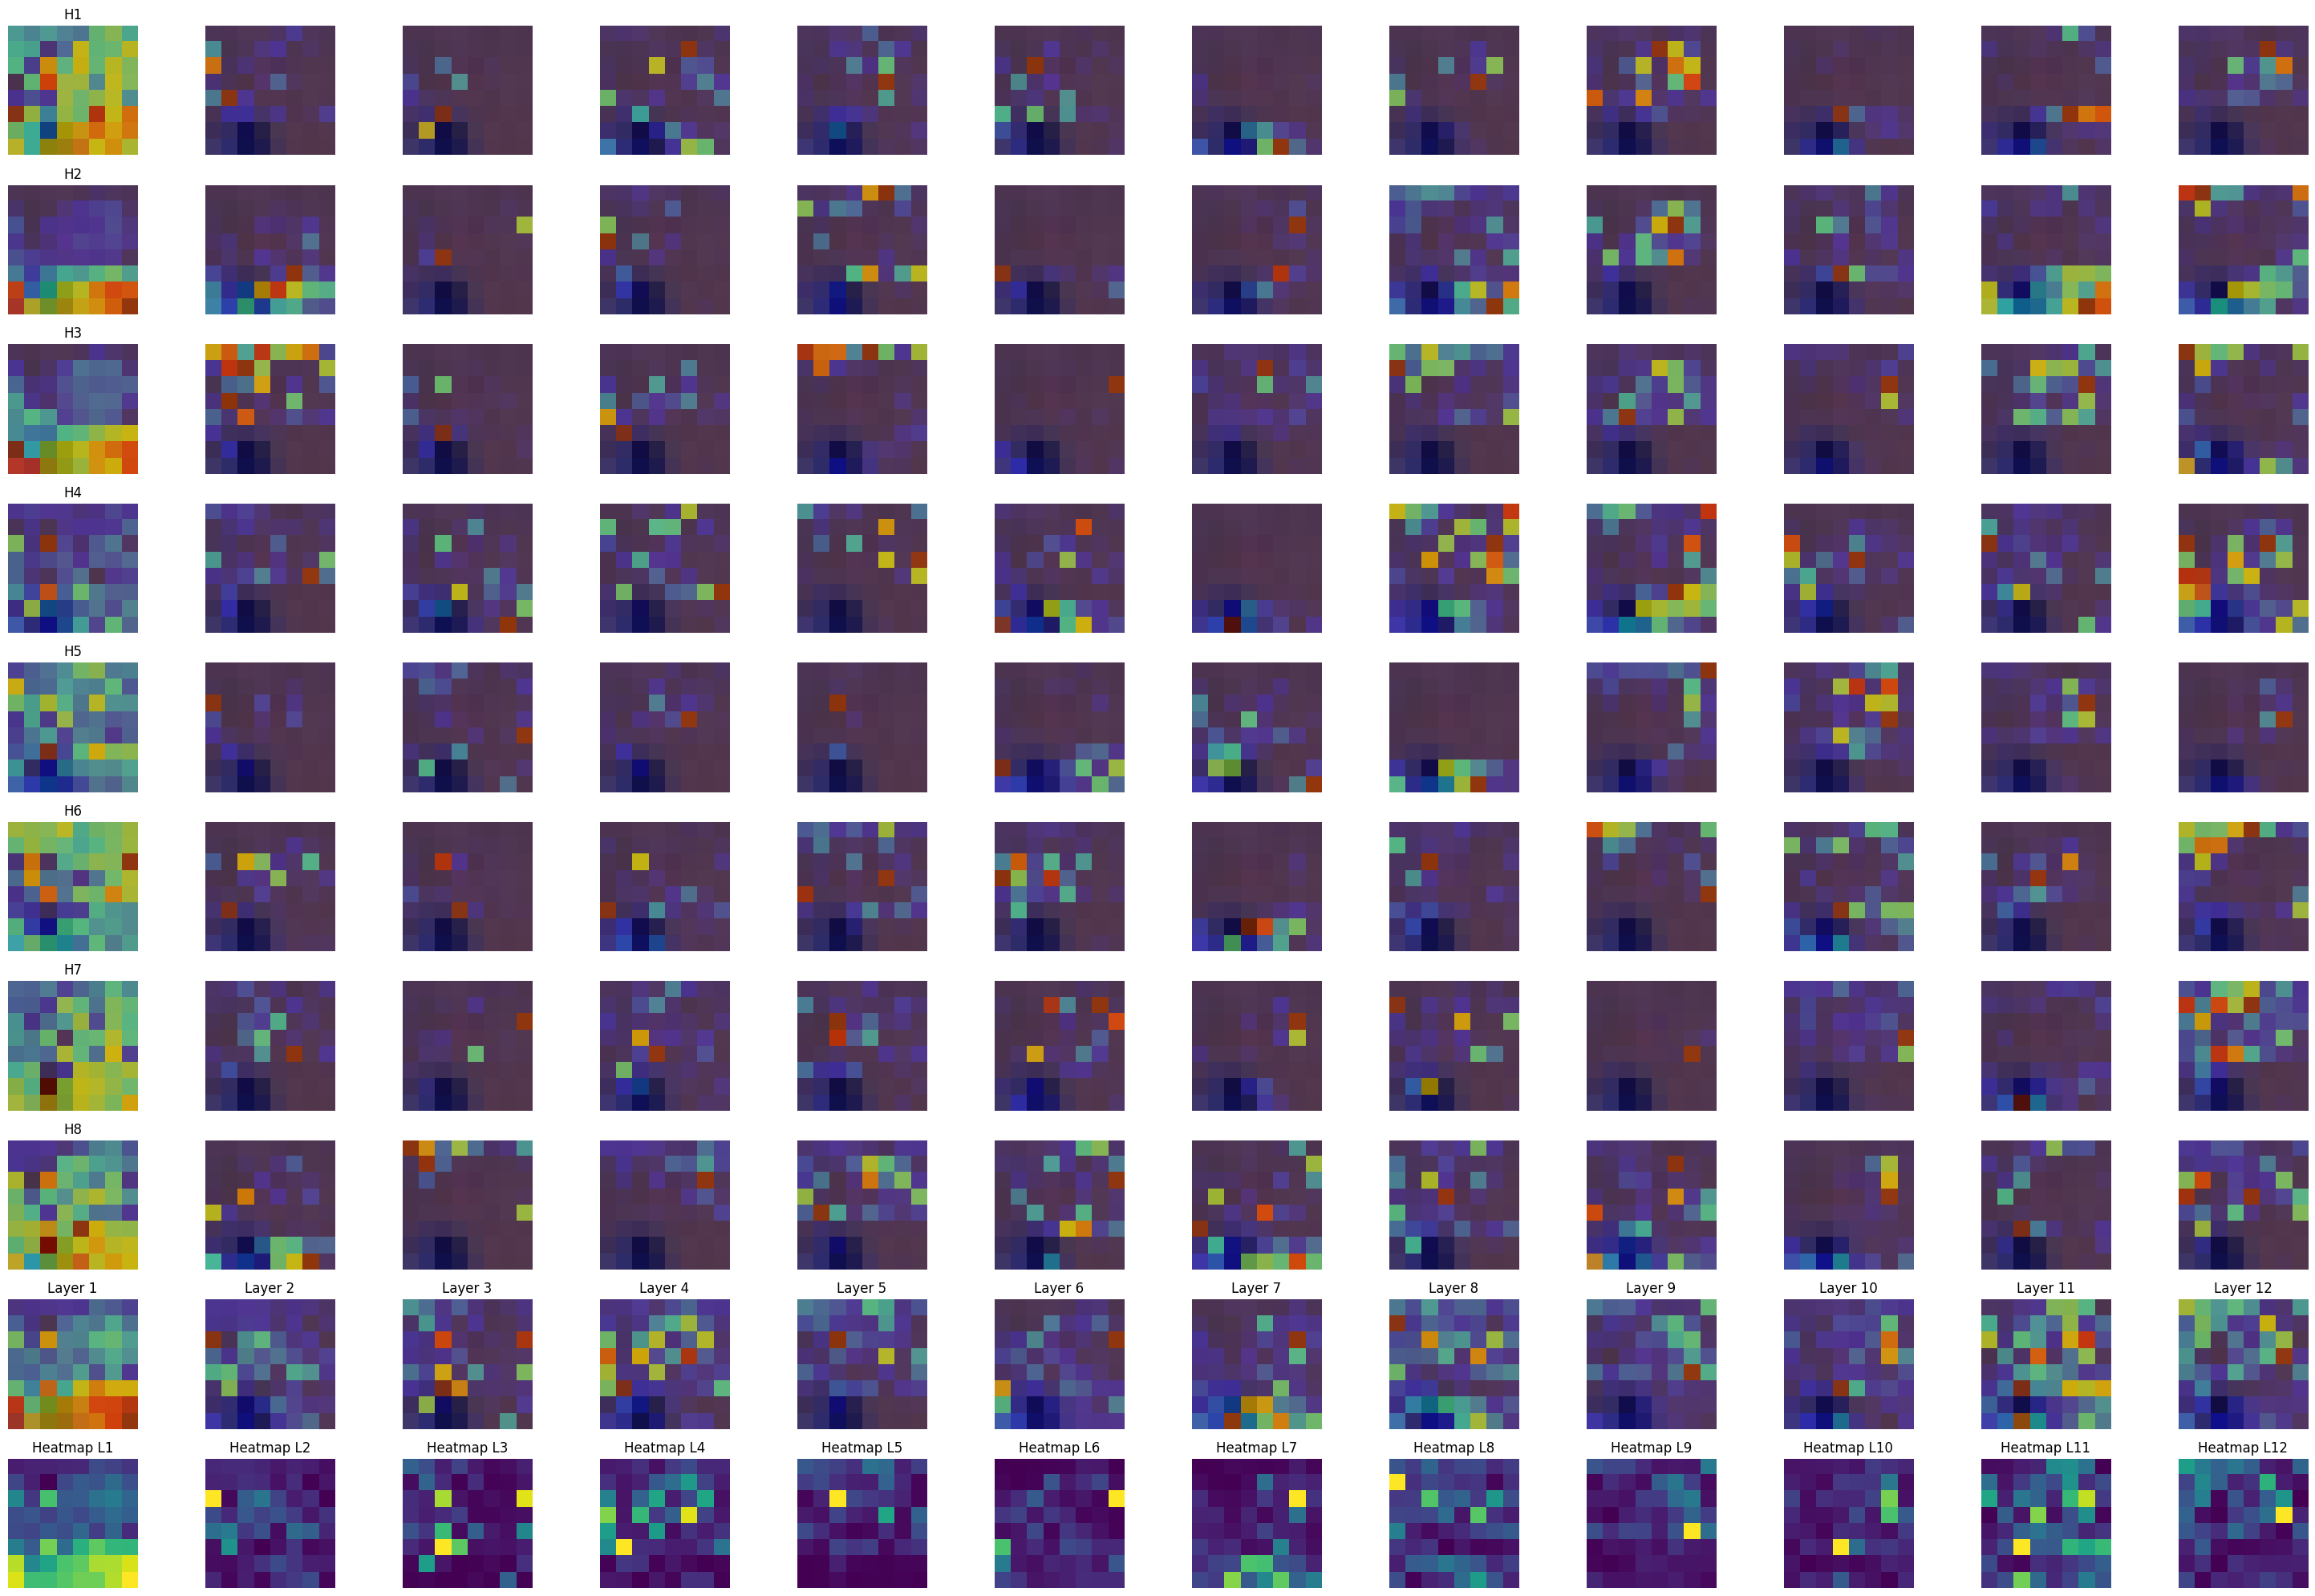

In [29]:
# 1. Hook function for capturing [CLS] attention maps from DiffViT
def get_cls_attentions_diffvit(model, x):
    attn_maps = []

    def hook_fn(module, input, output):
        attn = module.attn_weights  # (B, heads, N, N)
        cls_attn = attn[:, :, 0, 1:]  # CLS to patches only
        attn_maps.append(cls_attn.detach().cpu())

    handles = []
    for block in model.encoder_layers:
        handle = block.multihead_attention.register_forward_hook(hook_fn)
        handles.append(handle)

    with torch.no_grad():
        model(x)

    for handle in handles:
        handle.remove()

    return attn_maps
def show_attention_maps(image, attn_maps, patch_size=4):
    # Convert image to numpy for display
    img = image.permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())  # scales to [0,1]
    num_layers = len(attn_maps)
    num_heads = attn_maps[0].shape[1]
    num_patches = attn_maps[0].shape[2]
    grid_size = int(np.sqrt(num_patches))

    fig, axes = plt.subplots(num_heads + 2, num_layers, figsize=(num_layers * 2.5, (num_heads + 2) * 2))

    for layer_idx in range(num_layers):
        cls_attn = attn_maps[layer_idx][0]  # (heads, num_patches)

        for head_idx in range(num_heads):
            ax = axes[head_idx, layer_idx]
            attn = cls_attn[head_idx].reshape(grid_size, grid_size)
            ax.imshow(img)
            ax.imshow(attn, cmap='jet', alpha=0.5)
            ax.axis('off')
            if layer_idx == 0:
                ax.set_title(f'H{head_idx + 1}')

        # Average over heads
        avg_attn = cls_attn.mean(dim=0).reshape(grid_size, grid_size)
        ax = axes[num_heads, layer_idx]
        ax.imshow(img)
        ax.imshow(avg_attn, cmap='jet', alpha=0.5)
        ax.set_title(f'Layer {layer_idx + 1}')
        ax.axis('off')

        # Raw attention map
        ax = axes[num_heads + 1, layer_idx]
        ax.imshow(avg_attn, cmap='viridis')
        ax.set_title(f'Heatmap L{layer_idx + 1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# 2. Load your trained DiffViT model
diffvit_model = VisionTransformer(
    num_classes=10,
    embed_size=256,
    num_heads=8,
    num_layers=12,
    patch_size=4,
    feedforward_dim=1024,
    positional_embedding_type="none"  # or whichever you trained
)
diffvit_model.load_state_dict(torch.load('best_diffvit_deep.pth'))
diffvit_model = diffvit_model.to(device)
diffvit_model.eval()

# 3. Load a test image
test_iter = iter(test_loader)
img, label = next(test_iter)
img = img.to(device)

# 4. Get attention maps
attn_maps_diff = get_cls_attentions_diffvit(diffvit_model, img)

# 5. Visualize
show_attention_maps(img[0].cpu(), attn_maps_diff)

Attention rollout

C:\Users\SHARS\AppData\Local\Temp\ipykernel_39324\257013927.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_diffvit_deep.pth"))  

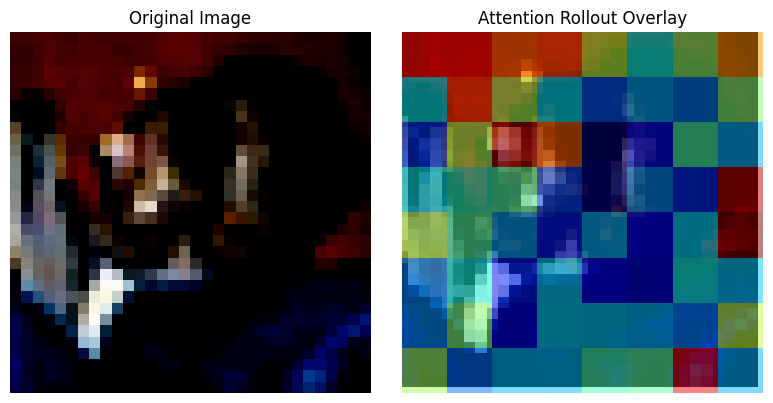

In [30]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Hook function to extract attention weights
def compute_attention_rollout(model, x):
    attn_matrices = []

    def hook_fn(module, input, output):
        # Extract attention weights (averaged over all heads)
        attn = output[1].detach().cpu()  # Shape: (B, heads, N, N)
        avg_attn = attn.mean(dim=1)  # Average across heads: (B, N, N)
        attn_matrices.append(avg_attn)

    handles = []
    for block in model.encoder_layers:
        handle = block.multihead_attention.register_forward_hook(hook_fn)
        handles.append(handle)

    with torch.no_grad():
        model(x)

    for handle in handles:
        handle.remove()

    # Start rollout: Identity matrix + attention
    rollout = torch.eye(attn_matrices[0].size(-1))  # Identity matrix for initial state
    for attn in attn_matrices:
        attn = attn[0]  # Take first image (batch size = 1)
        attn = attn + torch.eye(attn.size(0))  # Add residual connection (identity)
        attn = attn / attn.sum(dim=-1, keepdim=True)  # Normalize attention weights
        rollout = attn @ rollout  # Matrix multiplication (rollout)

    return rollout  # Shape: (num_tokens, num_tokens)

# Function to visualize attention rollout overlaid on the image
def show_attention_rollout_with_image(img_tensor, rollout, patch_size=4):
    img = img_tensor.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)  # Normalize image

    # Attention from [CLS] token to all patch tokens (skip [CLS] itself)
    cls_attn = rollout[0, 1:].numpy()  # Exclude [CLS] itself
    num_patches = cls_attn.shape[0]
    grid_size = int(np.sqrt(num_patches))

    attn_map = cls_attn.reshape(grid_size, grid_size)
    attn_map = attn_map / attn_map.max()  # Normalize for visualization

    # Create the plot
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    # Plot original image
    axs[0].imshow(img)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    # Plot image with attention rollout overlay
    axs[1].imshow(img)
    axs[1].imshow(attn_map, cmap='jet', alpha=0.5, extent=(0, 32, 32, 0))
    axs[1].set_title("Attention Rollout Overlay")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

# Loading the model and CIFAR-10 data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer(
    num_classes=10,
    embed_size=256,       # token embedding dimension
    num_heads=8,          # attention heads (reduced for stability/generalization)
    num_layers=12,         # slightly deeper transformer
    patch_size=4,
    feedforward_dim=1024,# hidden dim in each MLP block
).to(device)  # Assuming 10 classes for CIFAR-10
model.load_state_dict(torch.load("best_diffvit_deep.pth"))  # Uncomment to load pretrained model
model.eval()

# Get one test image from CIFAR-10
test_iter = iter(test_loader)
img, label = next(test_iter)
img = img[:1].to(device)  # Get just one image

# Compute the attention rollout
rollout = compute_attention_rollout(model, img)

# Visualize the original image and attention rollout overlay
show_attention_rollout_with_image(img[0].cpu(), rollout)